{'src_size': 1, 'tgt_size': 1, 'd_model': 256, 'num_heads': 2, 'num_layers': 2, 'd_ff': 1024, 'src_seq_length': 24, 'tgt_seq_length': 1, 'src_window': 8, 'tgt_window': 1, 'dropout': 0.2}


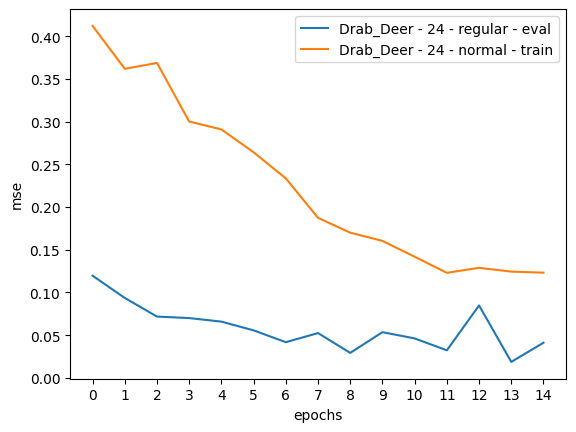

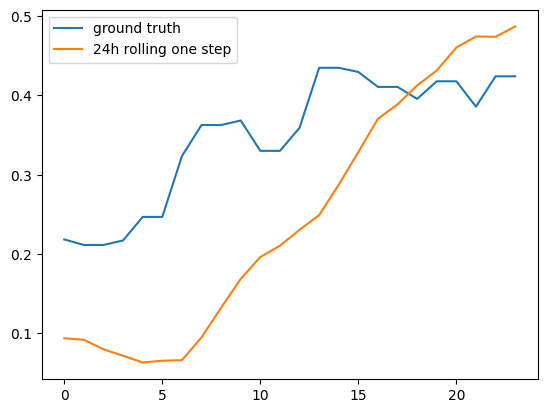

In [11]:
from eval_lib import load_model
from models import Transformer
from matplotlib import pyplot as plt
import numpy as np
import torch
from data_handling import data_loader
import utils

params, model, metrics = load_model('regular', 'Drab_Deer', 15, Transformer)

print(params)

max_len = 0
plt.plot(metrics['eval']['MSE'], label=f'Drab_Deer - {params["src_seq_length"]} - regular - eval')
plt.plot(np.arange(len(metrics['train']['MSE'])), metrics['train']['MSE'], label=f'Drab_Deer - {params["src_seq_length"]} - normal - train')
max_len = max(len(metrics['eval']['MSE']), max_len)
max_len = max(len(metrics['train']['MSE']), max_len)
plt.xticks(np.arange(max_len))
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

from trainer_lib.datasets import TimeSeriesWindowedTensorDataset, TimeSeriesWindowedDatasetConfig
df = data_loader.load_mavir_data('data/mavir_data/mavir.csv')
df['Power'] = utils.min_max_norm(df['Power'])
sample = utils.sample(df, 1000, start_idx=5000)
training_data = np.array(sample['Power'].to_numpy()[..., np.newaxis], dtype=np.float32)
shift, look_back, pred = 100, 24, 1

dataset = TimeSeriesWindowedTensorDataset(training_data, TimeSeriesWindowedDatasetConfig(params['src_window'], 
                                                                                     params['tgt_window'], 
                                                                                     params['src_seq_length'], 
                                                                                     params['tgt_seq_length'], 
                                                                                     1, 
                                                                                     False))
ones = torch.ones(1, 1, dataset[0][1].shape[-1])

with torch.no_grad():
    ground_truth = []
    predicted = []
    for shift_offset in range(shift, shift+24, 1):
        out = ones
        for i in range(pred):
            out = torch.concatenate((ones, model(dataset[shift_offset][0].unsqueeze(0), out)), dim=1)
    
        predicted.append(dataset.get_sequence_from_y_windows(out[:, 1:, :].detach()))
        ground_truth.append(dataset.get_sequence_from_y_windows(dataset[shift_offset][1]))
        
    predicted = np.array(predicted).reshape(24)
    ground_truth = np.array(ground_truth).reshape(24)
    plt.plot(ground_truth, label='ground truth')
    plt.plot(predicted, label='24h rolling one step')
        
plt.legend()
plt.show()